# 9.7.3 Nonrenewable Resource Management 

From Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section 9.7.3

## 設定

* 鉱山経営者が利潤を最大化する鉱石の掘り出し方を考えたい。

* 毎期sの鉱石残量が与えられ、xだけ採掘する。

* 各期の採掘コストはc(s,x)で　$$c_{s} \leq 0$$  $$c_{x} \geq 0$$  $$c_{s}(s,0)=0$$

* 各期の鉱石の市場価格はp(x)で　$$p' \leq 0$$

* 鉱石の初期賦存量に$\bar{s}$が与えられるとする。

##### state variable

$$s∈[{0,\bar{s}}]$$

##### action variable 

$$x∈[{0,s}]$$

##### transition function

$$g(s,x)=s-x$$

##### reward function

$$f(s,x) = p(x) x-c(s,x)$$

##### Bellman equation

$$V(s)=\max_ {0\leq x \leq s}  {p(x) x-c(s,x)+\delta V(s-x)}$$


In [1]:
using QuantEcon
using BasisMatrices
using Optim
using Interpolations
using Plots

* structでパラメーターの情報を格納

In [2]:
struct NonrenewableResource
    a1::Float64 # inverse demand function parameter
    a2::Float64 # inverse demand function parameter
    b1::Float64 # cost function parameter
    b2::Float64 # cost function parameter
    delta::Float64 # Discount factor
    s_vec::Vector{Float64} # ore grid
end

* 基底関数とノードの数、stateの上限と下限、を指定してfspaceにどのような補間をするかの情報を格納
* まず線形補間を行う

In [3]:
n = 100
smin = 0
smax = 10
fspace = Basis(ChebParams(n, smin, smax))
snodes = nodes(fspace)

([0.000616838, 0.00555063, 0.0154133, 0.0301952, 0.0498817, 0.0744534, 0.103886, 0.13815, 0.177213, 0.221035  …  9.77897, 9.82279, 9.86185, 9.89611, 9.92555, 9.95012, 9.9698, 9.98459, 9.99445, 9.99938], Array{Float64,1}[[0.000616838, 0.00555063, 0.0154133, 0.0301952, 0.0498817, 0.0744534, 0.103886, 0.13815, 0.177213, 0.221035  …  9.77897, 9.82279, 9.86185, 9.89611, 9.92555, 9.95012, 9.9698, 9.98459, 9.99445, 9.99938]])

In [4]:
NR = NonrenewableResource(10,0.8,12,1.0,0.9,snodes[1])

NonrenewableResource(10.0, 0.8, 12.0, 1.0, 0.9, [0.000616838, 0.00555063, 0.0154133, 0.0301952, 0.0498817, 0.0744534, 0.103886, 0.13815, 0.177213, 0.221035  …  9.77897, 9.82279, 9.86185, 9.89611, 9.92555, 9.95012, 9.9698, 9.98459, 9.99445, 9.99938])

* Initial guessを与えて、ベルマン方程式を更新していく

In [5]:
function update_Bellman1(NR::NonrenewableResource,V::Vector)
    a1,a2,b1,b2,delta = NR.a1,NR.a2,NR.b1,NR.b2,NR.delta
    V_new = similar(V)
    x_opt = similar(V)
    V_func = LinInterp(NR.s_vec, V)
    
    for (s_idx,s) in enumerate(NR.s_vec)
        objective(x) = -((a1-a2*x)*x-(b1*x-0.5*b2*x*(2s-x))+delta*V_func.(s-x))
        opt = optimize(objective, 1e-10, s)
        V_new[s_idx] = - opt.minimum
        x_opt[s_idx] = opt.minimizer
    end
    
    return V_new,x_opt
    
end

update_Bellman1 (generic function with 1 method)

In [6]:
# Initial guess
V = zeros(length(NR.s_vec));

In [7]:
V_computed = similar(V)
x_opt = similar(V)
resid1 = Vector{Float64}(n)
tol = sqrt(eps())
max_iter = 500
V_error = 1.0
i = 1

while V_error > tol && i <= max_iter
    V_computed ,x_opt = update_Bellman1(NR,V)
    V_error = maximum(abs, V_computed - V) 
    for j in 1:length(V_computed)
       resid1[j] =  V_computed[j] - V[j]
    end
    copy!(V,V_computed)
    i += 1
end

In [8]:
i

52

In [9]:
V_error

1.2445426023077744e-8


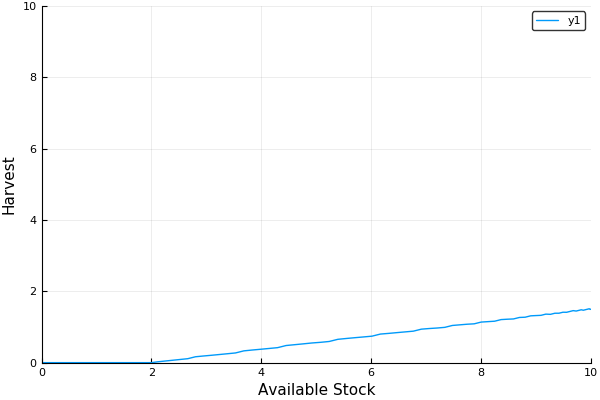

In [10]:
plot(NR.s_vec,x_opt,xlabel="Available Stock",ylabel="Harvest",xlim=(0,10),ylim=(0,10))


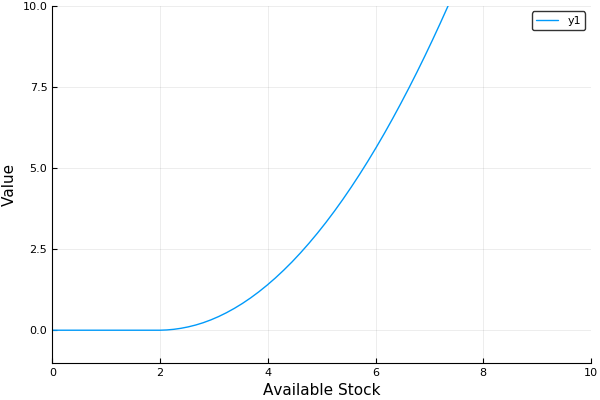

In [11]:
plot(NR.s_vec,V,xlabel="Available Stock",ylabel="Value",xlim=(0,10),ylim=(-1,10))


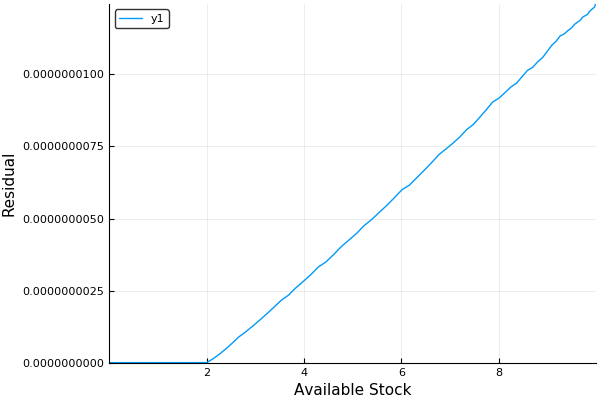

In [12]:
plot(NR.s_vec,resid1,xlabel="Available Stock",ylabel="Residual")

* 次にチェビシェフ補間を行う

In [13]:
function update_Bellman(NR::NonrenewableResource,V::Vector)
    
    a1,a2,b1,b2,delta = NR.a1,NR.a2,NR.b1,NR.b2,NR.delta
    V_new = similar(V)
    x_opt = similar(V)
    
    fspace = Basis(ChebParams(n,smin,smax))
    s_vec,_ = nodes(fspace)
    Φ = BasisMatrix(fspace, Expanded(), s_vec, 0)
    coeffs_V = Φ.vals[1] \ s_vec
    
    for (s_idx,s) in enumerate(NR.s_vec)
        objective(x) = -((a1-a2*x)*x-(b1*x-0.5*b2*x*(2s-x))+delta*(funeval(coeffs_V,fspace,s-x)))
        opt = optimize(objective, 1e-10, s)
        V_new[s_idx] = - opt.minimum
        x_opt[s_idx] = opt.minimizer
    end
    
    
    return V_new,x_opt
    
end


update_Bellman (generic function with 1 method)

In [14]:
# Initial guess
V = zeros(length(NR.s_vec));

In [15]:
fspace = Basis(ChebParams(n,smin,smax))
s_vec,_ = nodes(fspace)
Φ = BasisMatrix(fspace, Expanded(), s_vec, 0)
coeffs_V = Φ.vals[1] \ s_vec
V_computed = similar(V)
x_opt = similar(V)
resid = Vector{Float64}(n)
tol = sqrt(eps())
max_iter = 500
V_error = 1.0
i = 1

while V_error > tol && i <= max_iter
    V_computed ,x_opt = update_Bellman(NR,V)
    V_error = maximum(abs, V_computed - V) 
    #for j in 1:length(V_computed)
       #resid[j] =  V_computed[j] - V[j]
    #end
    for j in 1:length(V_computed)
       resid[j] =  V_computed[j] - funeval(coeffs_V,fspace,snodes[1][j])
    end
    copy!(V,V_computed)
    i += 1
end

In [16]:
i

3

In [17]:
V_error

0.0


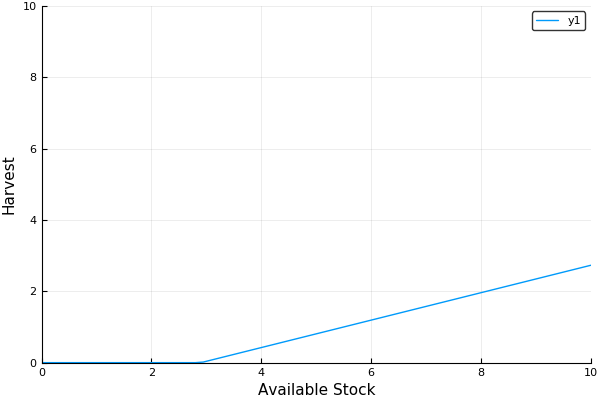

In [18]:
plot(NR.s_vec,x_opt,xlabel="Available Stock",ylabel="Harvest",xlim=(0,10),ylim=(0,10))


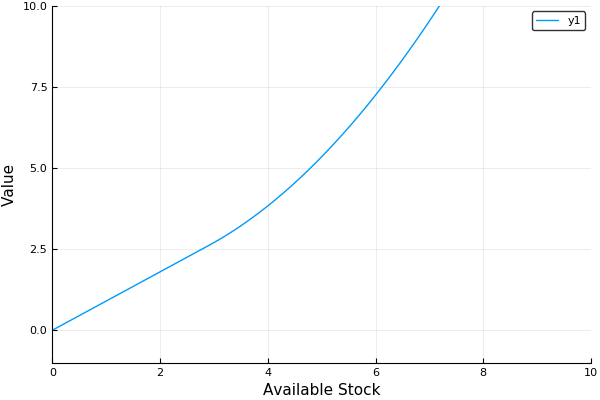

In [19]:
plot(NR.s_vec,V,xlabel="Available Stock",ylabel="Value",xlim=(0,10),ylim=(-1,10))


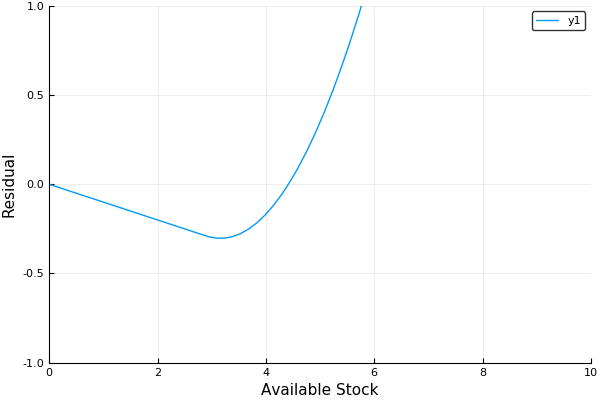

In [20]:
plot(NR.s_vec,resid,xlabel="Available Stock",ylabel="Residual",xlim=(0,10),ylim=(-1,1))

* 3次のスプライン補間を行う

In [21]:
n = 100
smin = 0
smax = 10
fspace = Basis(SplineParams(n,smin,smax,3))
snodes = nodes(fspace)
NR = NonrenewableResource(10.0,0.8,12.0,1.0,0.9,snodes[1])

NonrenewableResource(10.0, 0.8, 12.0, 1.0, 0.9, [0.0, 0.03367, 0.10101, 0.20202, 0.30303, 0.40404, 0.505051, 0.606061, 0.707071, 0.808081  …  9.19192, 9.29293, 9.39394, 9.49495, 9.59596, 9.69697, 9.79798, 9.89899, 9.96633, 10.0])

In [22]:
function update_Bellman3(NR::NonrenewableResource,V::Vector)
    
    a1,a2,b1,b2,delta = NR.a1,NR.a2,NR.b1,NR.b2,NR.delta
    V_new = similar(V)
    x_opt = similar(V)
    
    
    fspace = Basis(SplineParams(n-2,smin,smax,3))
    s_vec,_ = nodes(fspace)
    Φ = BasisMatrix(fspace, Expanded(), s_vec, 0)
    coeffs_V = Φ.vals[1] \ s_vec
    
    for (s_idx,s) in enumerate(NR.s_vec)
        objective(x) = -((a1-a2*x)*x-(b1*x-0.5*b2*x*(2s-x))+delta*(funeval(coeffs_V,fspace,s-x)))
        opt = optimize(objective, 0, s)
        V_new[s_idx] = - opt.minimum
        x_opt[s_idx] = opt.minimizer
        
    end
    
    return V_new,x_opt
    
end

update_Bellman3 (generic function with 1 method)

In [23]:
# Initial guess
V = zeros(length(NR.s_vec));

In [24]:
fspace = Basis(ChebParams(n-2,smin,smax))
s_vec,_ = nodes(fspace)
Φ = BasisMatrix(fspace, Expanded(), s_vec, 0)
coeffs_V = Φ.vals[1] \ s_vec
V_computed = similar(V)
x_opt = similar(V)
resid3 = Vector{Float64}(n)
tol = sqrt(eps())
max_iter = 500
V_error = 1.0
i = 1

while V_error > tol && i <= max_iter
    V_computed ,x_opt = update_Bellman3(NR,V)
    V_error = maximum(abs, V_computed - V) 
    #for j in 1:length(V_computed)
     #  resid3[j] =  V_computed[j] - V[j]
    #end
    for j in 1:length(V_computed)
       resid3[j] =  V_computed[j] - funeval(coeffs_V,fspace,snodes[1][j])
    end
    copy!(V,V_computed)
    i += 1
end

In [25]:
i

3

In [26]:
V_error

0.0


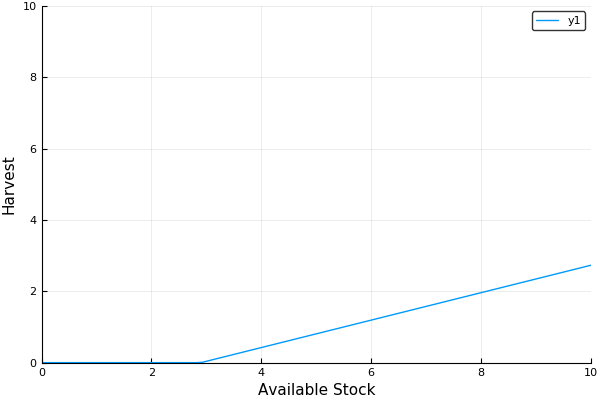

In [27]:
plot(NR.s_vec,x_opt,xlabel="Available Stock",ylabel="Harvest",xlim=(0,10),ylim=(0,10))


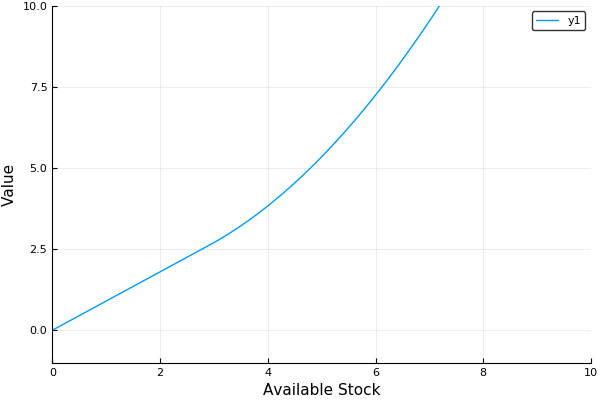

In [28]:
plot(NR.s_vec,V,xlabel="Available Stock",ylabel="Value",xlim=(0,10),ylim=(-1,10))


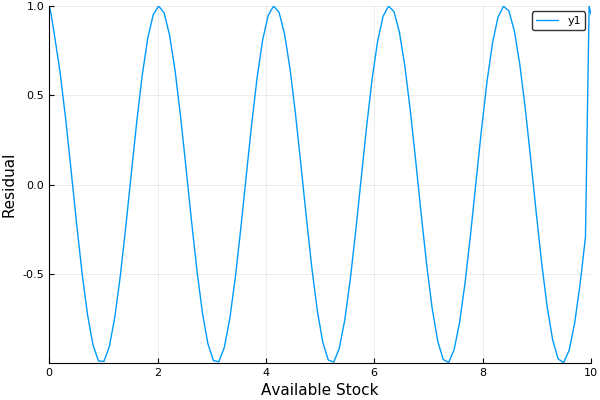

In [29]:
plot(NR.s_vec,resid3,xlabel="Available Stock",ylabel="Residual")